Source Dataset : https://www.kaggle.com/ajay1735/hmeq-data

# Problem Statement

**Context** <br>
Departemen kredit konsumen sebuah bank ingin mengotomatisasi proses pengambilan keputusan untuk persetujuan jalur kredit ekuitas rumah. Untuk melakukan ini, mereka akan mengikuti rekomendasi dari Equal Credit Opportunity Act untuk membuat model penilaian kredit yang diturunkan secara empiris dan sehat secara statistik. Model ini akan didasarkan pada data yang dikumpulkan dari pemohon yang baru saja diberikan kredit melalui proses penjaminan pinjaman saat ini. Model akan dibangun dari alat pemodelan prediktif, tetapi model yang dibuat harus cukup dapat diinterpretasikan untuk memberikan alasan untuk setiap tindakan yang merugikan (penolakan).

**Content** <br>
Dataset Ekuitas Rumah (HMEQ) berisi informasi dasar dan kinerja pinjaman untuk 5.960 pinjaman ekuitas rumah baru-baru ini. Target (BAD) adalah variabel biner yang menunjukkan apakah pelamar akhirnya gagal atau benar-benar tunggakan. Hasil buruk ini terjadi pada 1.189 kasus (20%). Untuk setiap pelamar, 12 variabel input dicatat.

**Goals** <br>
Memprediksi apakah seseorang akan gagal membayar pinjaman atau tidak, berdasarkan atribut yang diberikan.

## Attribute Overview 
- BAD: 1 = pemohon gagal dalam pinjaman atau tunggakan yang serius; 0= pinjaman yang dibayar pemohon (Variabel Target){Nominal Biner Assimetris}
- LOAN: Jumlah permintaan pinjaman{Rasio-Skala Numerik}
- MORTDUE: Jumlah yang harus dibayar pada hipotek yang ada{Rasio-Skala Numerik}
- VALUE: Nilai properti saat ini{Rasio-Skala Numerik}
- REASON: DebtCon = konsolidasi hutang; homelmp = Perbaikan rumah{Nominal}
- JOB: Kategori pekerjaan{Nominal}
- YOJ: Tahun di pekerjaan sekarang
- DEROG: Jumlah laporan penghinaan utama
- DELINQ: Jumlah kredit yang menunggak
- CLAGE: Usia batas kredit tertua dalam beberapa bulan
- NINQ: Jumlah pertanyaan kredit terbaru
- CLNO: Jumlah jalur kredit
- DEBTINC: Rasio utang terhadap pendapatan{Rasio-Skala Numerik}

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')
%load_ext autotime

time: 0 ns (started: 2022-01-01 18:08:32 +07:00)


In [2]:
# Pyplot and seaborn style
sns.set(style="whitegrid")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
colormap = sns.diverging_palette(220, 10, as_cmap=True)

time: 32 ms (started: 2022-01-01 18:08:32 +07:00)


# Data Exploration 

Pada tahap ini dilakukan eksplorasi data, seperti dimensi data, tipe data setiap kolom, statistik deskriptif data, mengecek apakah terdapat missing value, dan duplikat data. 

## Load  Dataset

In [3]:
# Load dataset 
df = pd.read_csv('hmeq.csv')
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


time: 140 ms (started: 2022-01-01 18:08:32 +07:00)


## Data Information 

In [4]:
# dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB
time: 47 ms (started: 2022-01-01 18:08:32 +07:00)


## Statistics Description

In [5]:
# statistics description 
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


time: 141 ms (started: 2022-01-01 18:08:32 +07:00)


In [6]:
# statistics for categorical data
df.select_dtypes('object').describe()

,REASON,JOB
count,5708,5681
unique,2,6
top,DebtCon,Other
freq,3928,2388


time: 78 ms (started: 2022-01-01 18:08:32 +07:00)


## Check Null and Misssing Values

Periksa missing values untuk setiap featurem hitung jumlah dan persentasenya.

In [7]:
# number of missing data
null_values = df.isna().sum()

# Round the percentage result
pct_null_values = round((df.isna().sum()/df.shape[0]*100), 2)

# Create a dataframe for the total amount and percentage of missing data
df_null_values = pd.DataFrame(data=null_values, columns=['Total']).reset_index()
df_null_values.rename(columns={'index':'Feature'}, inplace=True)

# Assign pertencage to dataframe
df_null_values['Percentage'] = pct_null_values.values

# filter for missing data more than zero
df_null_values = df_null_values[df_null_values['Total'] > 0]
df_null_values

,Feature,Total,Percentage
2,MORTDUE,518,8.69
3,VALUE,112,1.88
4,REASON,252,4.23
5,JOB,279,4.68
6,YOJ,515,8.64
7,DEROG,708,11.88
8,DELINQ,580,9.73
9,CLAGE,308,5.17
10,NINQ,510,8.56
11,CLNO,222,3.72


time: 141 ms (started: 2022-01-01 18:08:32 +07:00)


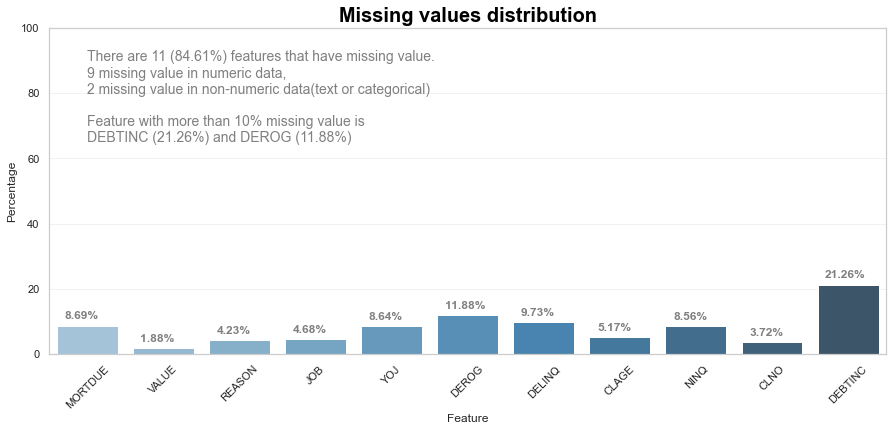

time: 688 ms (started: 2022-01-01 18:08:33 +07:00)


In [8]:
# Plotting number of missing data
fig, ax = plt.subplots(figsize=(15,6))

g = sns.barplot(x = 'Feature',y='Percentage',data=df_null_values,ax=ax, 
               palette=sns.color_palette("Blues_d", n_colors=13, desat=1))

x = np.arange(len(df_null_values['Feature']))
y = df_null_values['Percentage']

for i, v in enumerate(y):
    ax.text(x[i]-0.3, v+2, str(v)+'%', fontsize = 12, color='gray', fontweight='bold')
    

text = '''
There are 11 (84.61%) features that have missing value.
9 missing value in numeric data,
2 missing value in non-numeric data(text or categorical)

Feature with more than 10% missing value is  
DEBTINC (21.26%) and DEROG (11.88%)
'''
ax.text(0,60,text,horizontalalignment='left',color='gray',fontsize=14,fontweight='normal')
ax.set_title('Missing values distribution', color='black', fontsize=20, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_ylim(0,100)
plt.show()

## Check Duplicated Data

Cek apakah terdapat data yang duplikat, jika ada maka hapus data tersebut.

In [9]:
# Check duplicated data
df[df.duplicated()]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC


time: 31 ms (started: 2022-01-01 18:08:33 +07:00)


Terlihat bahwa data yang kita miliki tidak mempunyai data duplikat.

# Data Cleansing

Pada tahap ini lakukan pembersihan data, mulai dari handling missing value, inconsistent data, outliers, dan konversi  tipe data setiap feature sesuai dengan seharusnya.

## Check Cardinality

Cek apakah terdapat data yang tidak konsisten pada setiap feature. Periksa juga jumlah unik data pada setiap feature.

In [10]:
# get all categorical columns
col_cat = df.select_dtypes('object').columns

# loops for categorical data
for i in col_cat:
    print(df[i].value_counts())
    print()

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64

time: 47 ms (started: 2022-01-01 18:08:33 +07:00)


In [11]:
# The number of unique values of each feature
for i in df.columns:
    print(i, ':', df[i].nunique())

BAD : 2
LOAN : 540
MORTDUE : 5053
VALUE : 5381
REASON : 2
JOB : 6
YOJ : 99
DEROG : 11
DELINQ : 14
CLAGE : 5314
NINQ : 16
CLNO : 62
DEBTINC : 4693
time: 63 ms (started: 2022-01-01 18:08:34 +07:00)


## Handling Missing Values

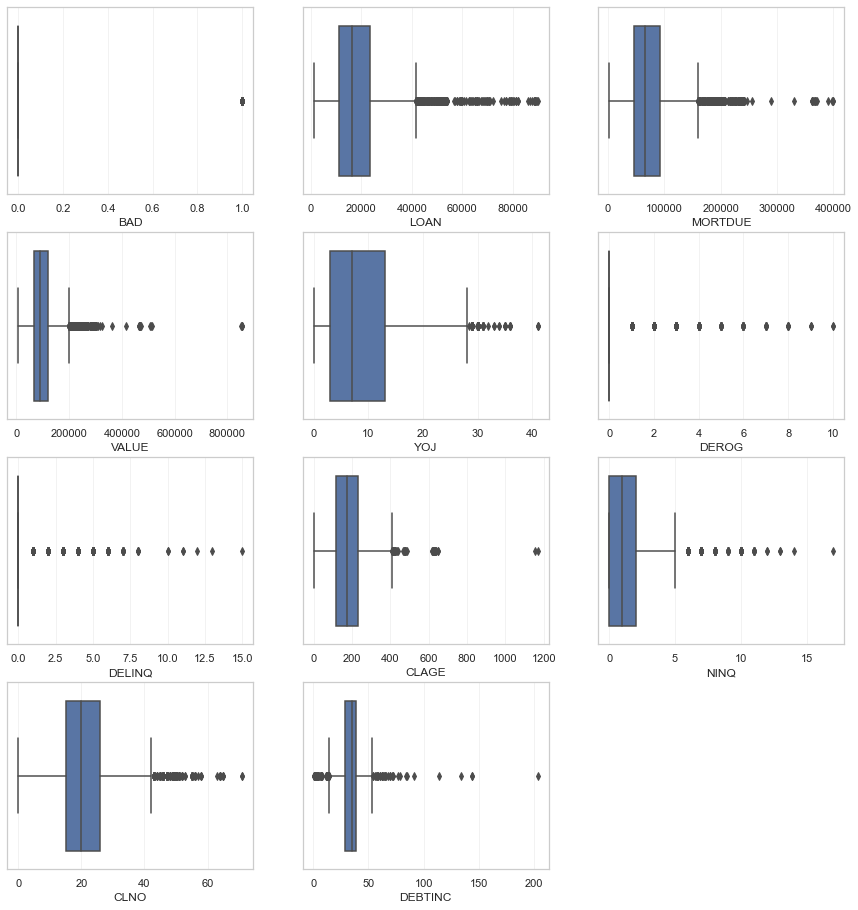

time: 3 s (started: 2022-01-01 18:08:34 +07:00)


In [12]:
# get all numerical columns
num_col = df.select_dtypes('number').columns

plt.figure(figsize=(15, 20))
pos = 1

# Loops for numerical feature 
for i in num_col:
    plt.subplot(5, 3, pos)
    sns.boxplot(data=df, x=i)
    pos += 1

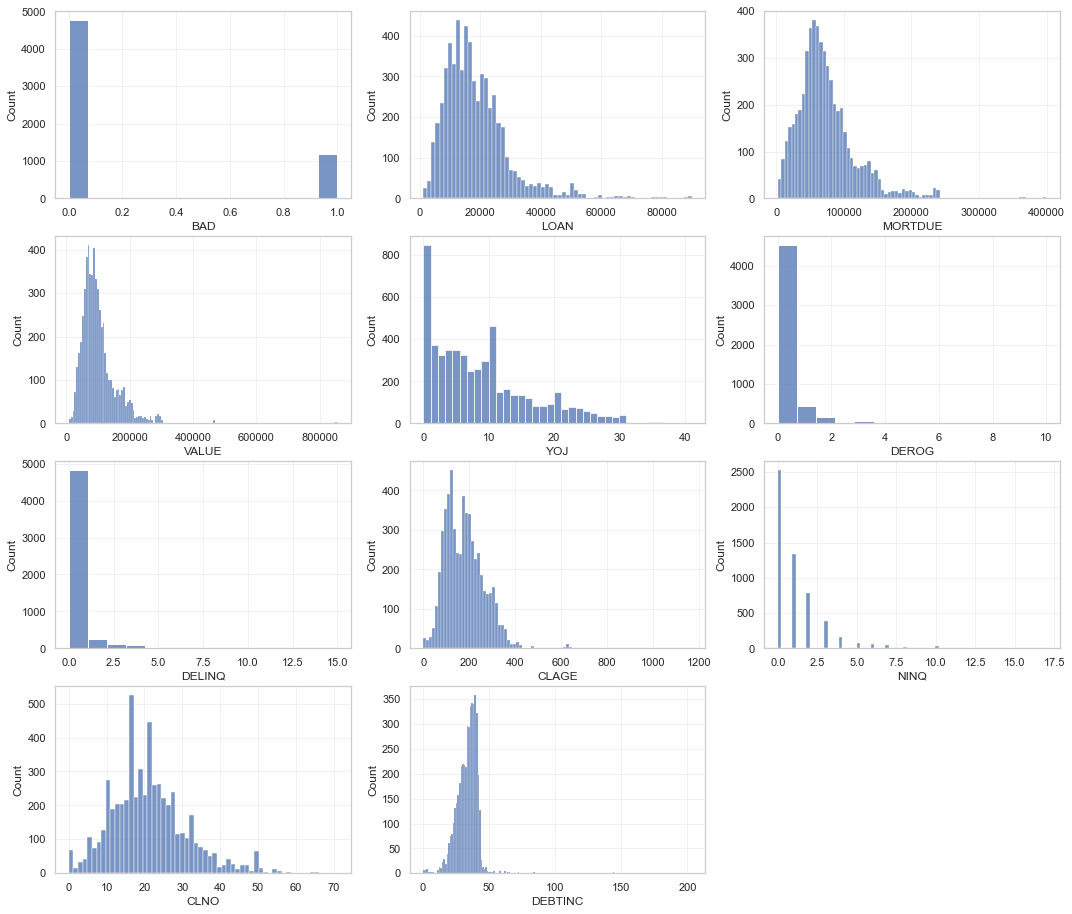

time: 5.45 s (started: 2022-01-01 18:08:37 +07:00)


In [13]:
plt.figure(figsize=(18, 20))
pos = 1

# Loops for numerical feature 
for i in num_col:
    plt.subplot(5, 3, pos)
    sns.histplot(data=df, x=i)
    pos += 1

Karena terdapat missing value, maka kita harus mengisi nilai tersebut. Pada data kategorikal kita bisa mengisinya menggunakan modus. Terdapat beberapa skenario untuk melakukan hal tersebut.
- REASON : Feature ini merupakan alasan pemohon mengajukan pinjaman. Ada dua alasan, yaitu konsolidasi hutang dan perbaikan rumah. Karena terdapat data yang hilang, bisa diasumsikan bahwa pemohon tidak menyebutkan alasan dirinya meminjam. Jadi pada feature ini bisa diisii alasan lain (Other)
- JOB : feature ini merupakan pekerjaan pemohon. Terdapat enam nilai unik pada feeature ini, dan "Other" yang paling banyak muncul. Maka kita bisa mengisi dengan nilai ini.    
- Karena data yang kita miliki terdapat banyak outliers, maka kita bisa gunakan nilai median untuk mengisi missing values (data numerik).  

In [14]:
# Replace REASON with Other
df['REASON'].fillna('Other', inplace=True)
# FIlling JOB with mode 
df['JOB'].fillna(df['JOB'].mode()[0], inplace=True)

time: 0 ns (started: 2022-01-01 18:08:42 +07:00)


In [15]:
# Filling missing values with median
df.fillna(df.median(), inplace=True)

time: 78 ms (started: 2022-01-01 18:08:42 +07:00)


In [16]:
# Make sure there are no missing values
df.isna().any()

BAD        False
LOAN       False
MORTDUE    False
VALUE      False
REASON     False
JOB        False
YOJ        False
DEROG      False
DELINQ     False
CLAGE      False
NINQ       False
CLNO       False
DEBTINC    False
dtype: bool

time: 94 ms (started: 2022-01-01 18:08:43 +07:00)


## Handling Outliers

Karena terdapat banyak outliers, maka kita akan menghapus menggunakan metode IQR (Inter-quartile Range).

In [17]:
# Define function to remove outliers
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_final

time: 47 ms (started: 2022-01-01 18:08:43 +07:00)


In [18]:
# Call function to remove outliers
df_drop_outliers = remove_outlier_IQR(df)

# Number of outliers has been removed
number_drop_outliers = df.shape[0]-df_drop_outliers.shape[0]
# percentage number of outliers
pct_number_drop_outliers = (number_drop_outliers/df.shape[0])
print("Jumlah data yang dihapus ada {} baris ({:.2%}) dari keseluruhan data.".format(number_drop_outliers,pct_number_drop_outliers))

Jumlah data yang dihapus ada 2961 baris (49.68%) dari keseluruhan data.
time: 141 ms (started: 2022-01-01 18:08:43 +07:00)


Karena data outliers yang dihapus menyebabkan kita kehilangan banyak data (lebih dari 50%), maka kita tidak akan menghapus data outliers. Kita akan menangani data tersebut pada tahap Feature Engineering. 

## Data Type Transformation

### DELINQ, NINQ, CLNO

In [19]:
# Create list for DELINQ, NINQ, CLNO feature
col = ['DELINQ', 'NINQ', 'CLNO']

# Loops for col list
for i in col:
    print(df[i].unique())

[ 0.  2.  1.  6. 15.  4.  3.  5.  7.  8. 10. 12. 11. 13.]
[ 1.  0.  2.  3.  5. 14. 10.  4.  9.  8.  6.  7. 11. 12. 17. 13.]
[ 9. 14. 10. 20.  8. 17. 12. 13. 25. 24. 16. 22.  0.  4. 21. 19. 45. 26.
 37.  3.  2. 27.  7. 36. 33.  6. 28. 11. 31. 15. 18. 23.  5. 30. 34. 42.
 50. 47. 32. 29. 46. 38. 40. 49. 43. 35.  1. 56. 39. 51. 55. 65. 57. 41.
 71. 48. 53. 64. 52. 63. 44. 58.]
time: 78 ms (started: 2022-01-01 18:08:43 +07:00)


Karena pada feature DELINQ, NINQ, dan CLNO itu seharunya angka integer, maka kita ubah tipe datanya menjadi integer.

In [20]:
# Convert DELINQ, NINQ, CLNO to integer
for i in col:
    df[i] = df[i].astype('int')

time: 125 ms (started: 2022-01-01 18:08:43 +07:00)


### REASON AND JOB

In [21]:
# Get all categorical feature
col_cat = df.select_dtypes('object').columns

# Convert categorical feature to category data type
for i in col_cat:
    df[i] = df[i].astype('category')

time: 141 ms (started: 2022-01-01 18:08:43 +07:00)


Feature JOB dan REASON juga kita ubah menjadi tipe data category karena data tersebut termasuk data kategorikal.  

In [22]:
# Make sure that data type has changed
df.dtypes

BAD           int64
LOAN          int64
MORTDUE     float64
VALUE       float64
REASON     category
JOB        category
YOJ         float64
DEROG       float64
DELINQ        int32
CLAGE       float64
NINQ          int32
CLNO          int32
DEBTINC     float64
dtype: object

time: 32 ms (started: 2022-01-01 18:08:44 +07:00)


# Exploratory Data Analysis

Pada tahap EDA ini dilakukan eksplorasi pada data, seperti distribusi pemohon pinjaman, distribusi jumlah pinjaman dan lain-lain.  

## BAD

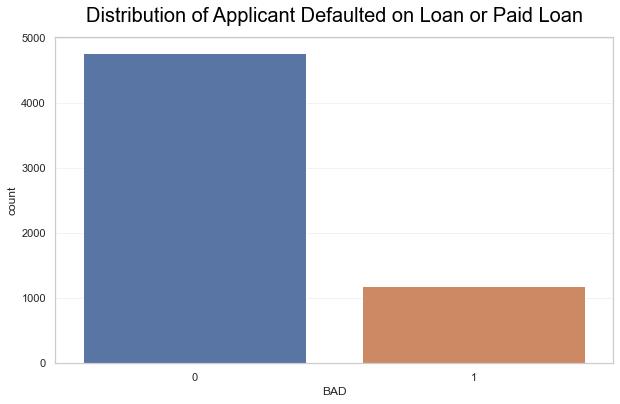

time: 360 ms (started: 2022-01-01 18:08:44 +07:00)


In [23]:
# Plotting distribution of applicant defaulted on loan or paid loan
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='BAD')
plt.title('Distribution of Applicant Defaulted on Loan or Paid Loan', fontsize=20, color='black', pad=15)
plt.show()

## LOAN

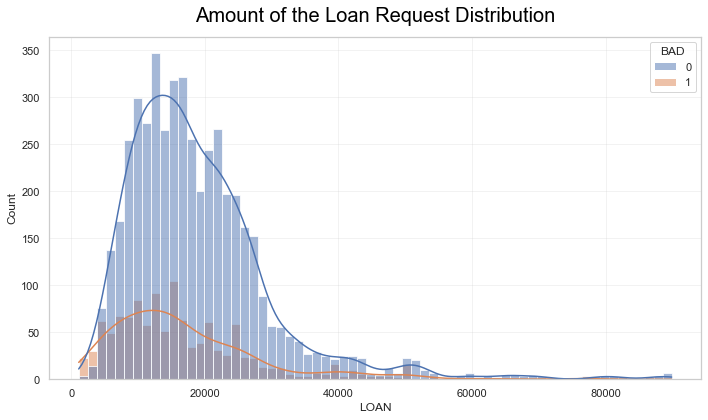

time: 1.03 s (started: 2022-01-01 18:08:44 +07:00)


In [24]:
# Plotting amount of the loan request distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='LOAN', kde=True, hue='BAD')
plt.title('Amount of the Loan Request Distribution', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

## MORTDUE

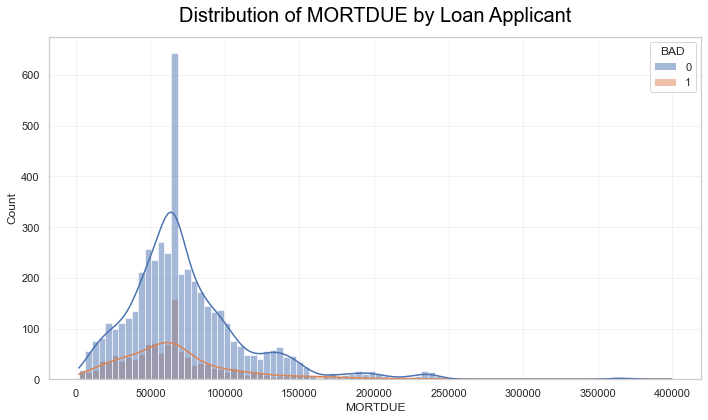

time: 1.62 s (started: 2022-01-01 18:08:45 +07:00)


In [25]:
# Plotting Distribution of MORTDUE by Loan Applicant
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='MORTDUE', kde=True, hue='BAD')
plt.title('Distribution of MORTDUE by Loan Applicant', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

## VALUE

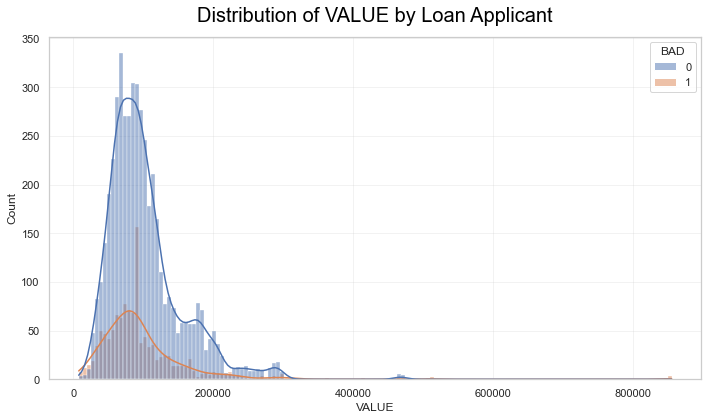

time: 2.28 s (started: 2022-01-01 18:08:47 +07:00)


In [26]:
# Plotting Distribution of VALUE by Loan Applicant
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='VALUE', kde=True, hue='BAD')
plt.title('Distribution of VALUE by Loan Applicant', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

## REASON

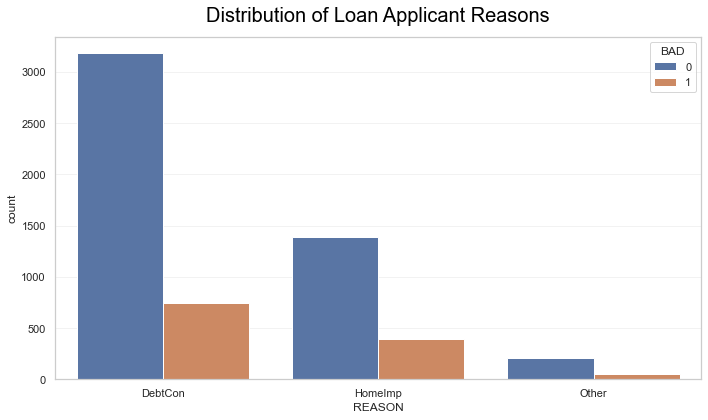

time: 437 ms (started: 2022-01-01 18:08:49 +07:00)


In [27]:
# Plotting Distribution of Loan Applicant Reasons
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='REASON', hue='BAD')
plt.title('Distribution of Loan Applicant Reasons', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

## JOB

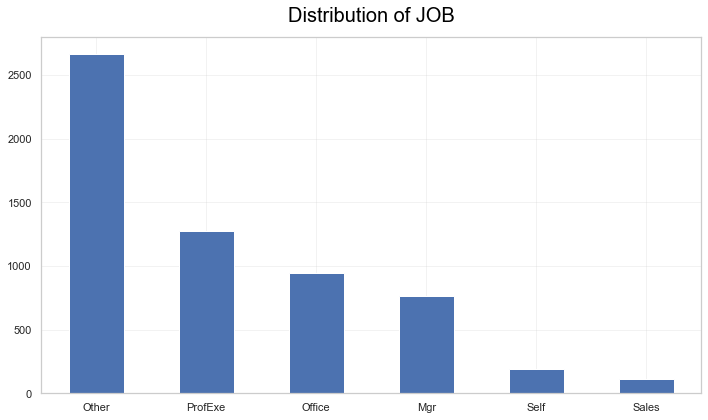

time: 391 ms (started: 2022-01-01 18:08:50 +07:00)


In [28]:
# Plotting Distribution of JOB
plt.figure(figsize=(10, 6))
df['JOB'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Distribution of JOB', fontsize=20, color='black', pad=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## DEROG

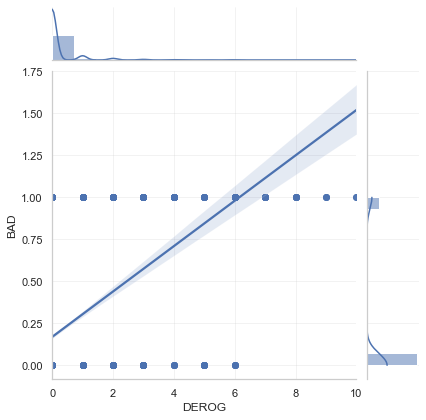

time: 1.66 s (started: 2022-01-01 18:08:50 +07:00)


In [29]:
# Plotting DEROG feature
sns.jointplot(x="DEROG", y="BAD", data=df, kind="reg")
plt.show()

## DELINQ

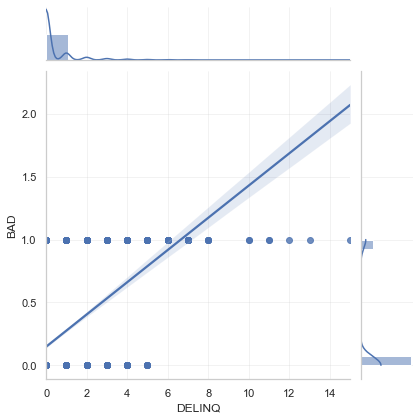

time: 1.59 s (started: 2022-01-01 18:08:52 +07:00)


In [30]:
# Plotting DELINQ feature
sns.jointplot(x="DELINQ", y="BAD", data=df, kind="reg")
plt.show()

## CLAGE

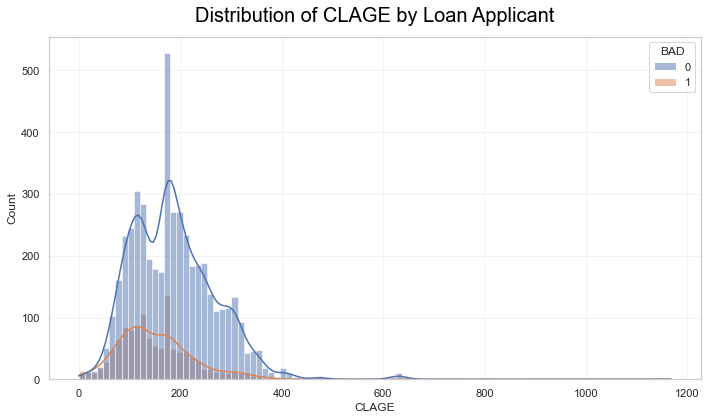

time: 1.53 s (started: 2022-01-01 18:08:54 +07:00)


In [31]:
# Plotting Distribution of CLAGE by Loan Applicant
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='CLAGE', kde=True, hue='BAD')
plt.title('Distribution of CLAGE by Loan Applicant', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

## NINQ

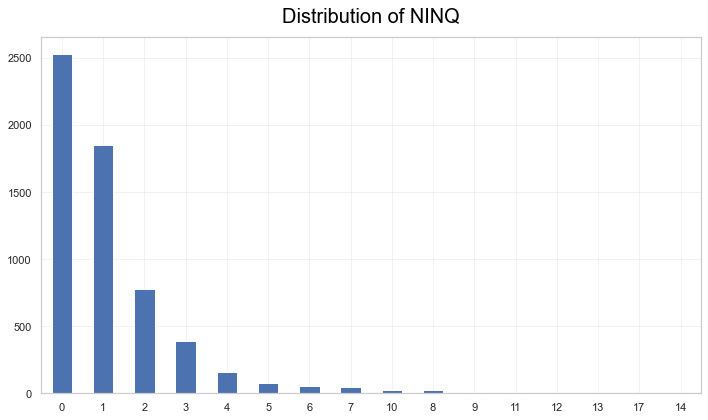

time: 750 ms (started: 2022-01-01 18:08:55 +07:00)


In [32]:
# Plotting Distribution of NINQ
plt.figure(figsize=(10, 6))
df['NINQ'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Distribution of NINQ', fontsize=20, color='black', pad=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## CLNO

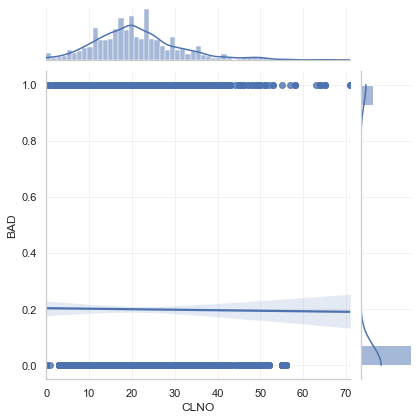

time: 2.39 s (started: 2022-01-01 18:08:56 +07:00)


In [33]:
# Plotting CLNO feature
sns.jointplot(x="CLNO", y="BAD", data=df, kind="reg")
plt.show()

## DEBTINC

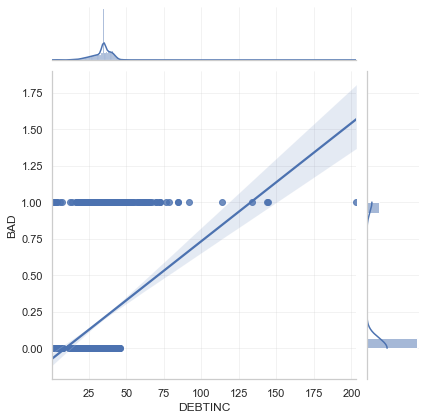

time: 2.17 s (started: 2022-01-01 18:08:59 +07:00)


In [34]:
# Plotting DEBTINC feature
sns.jointplot(x="DEBTINC", y="BAD", data=df, kind="reg")
plt.show()

## Correlation Features

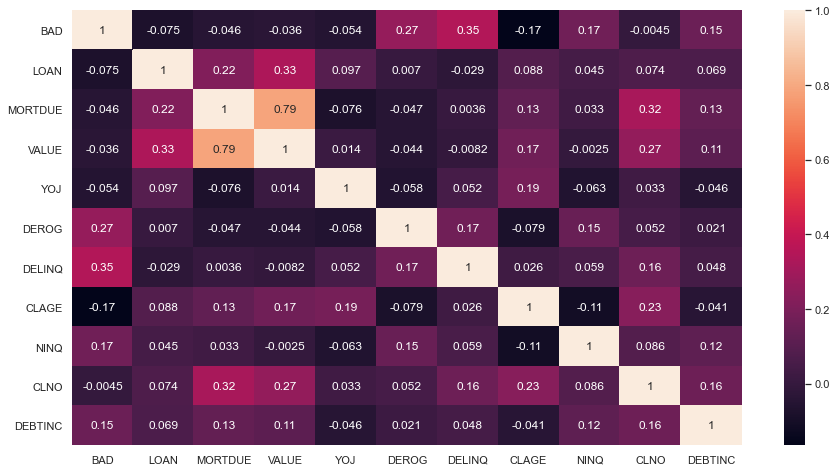

time: 3.11 s (started: 2022-01-01 18:09:01 +07:00)


In [35]:
# Correlation heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

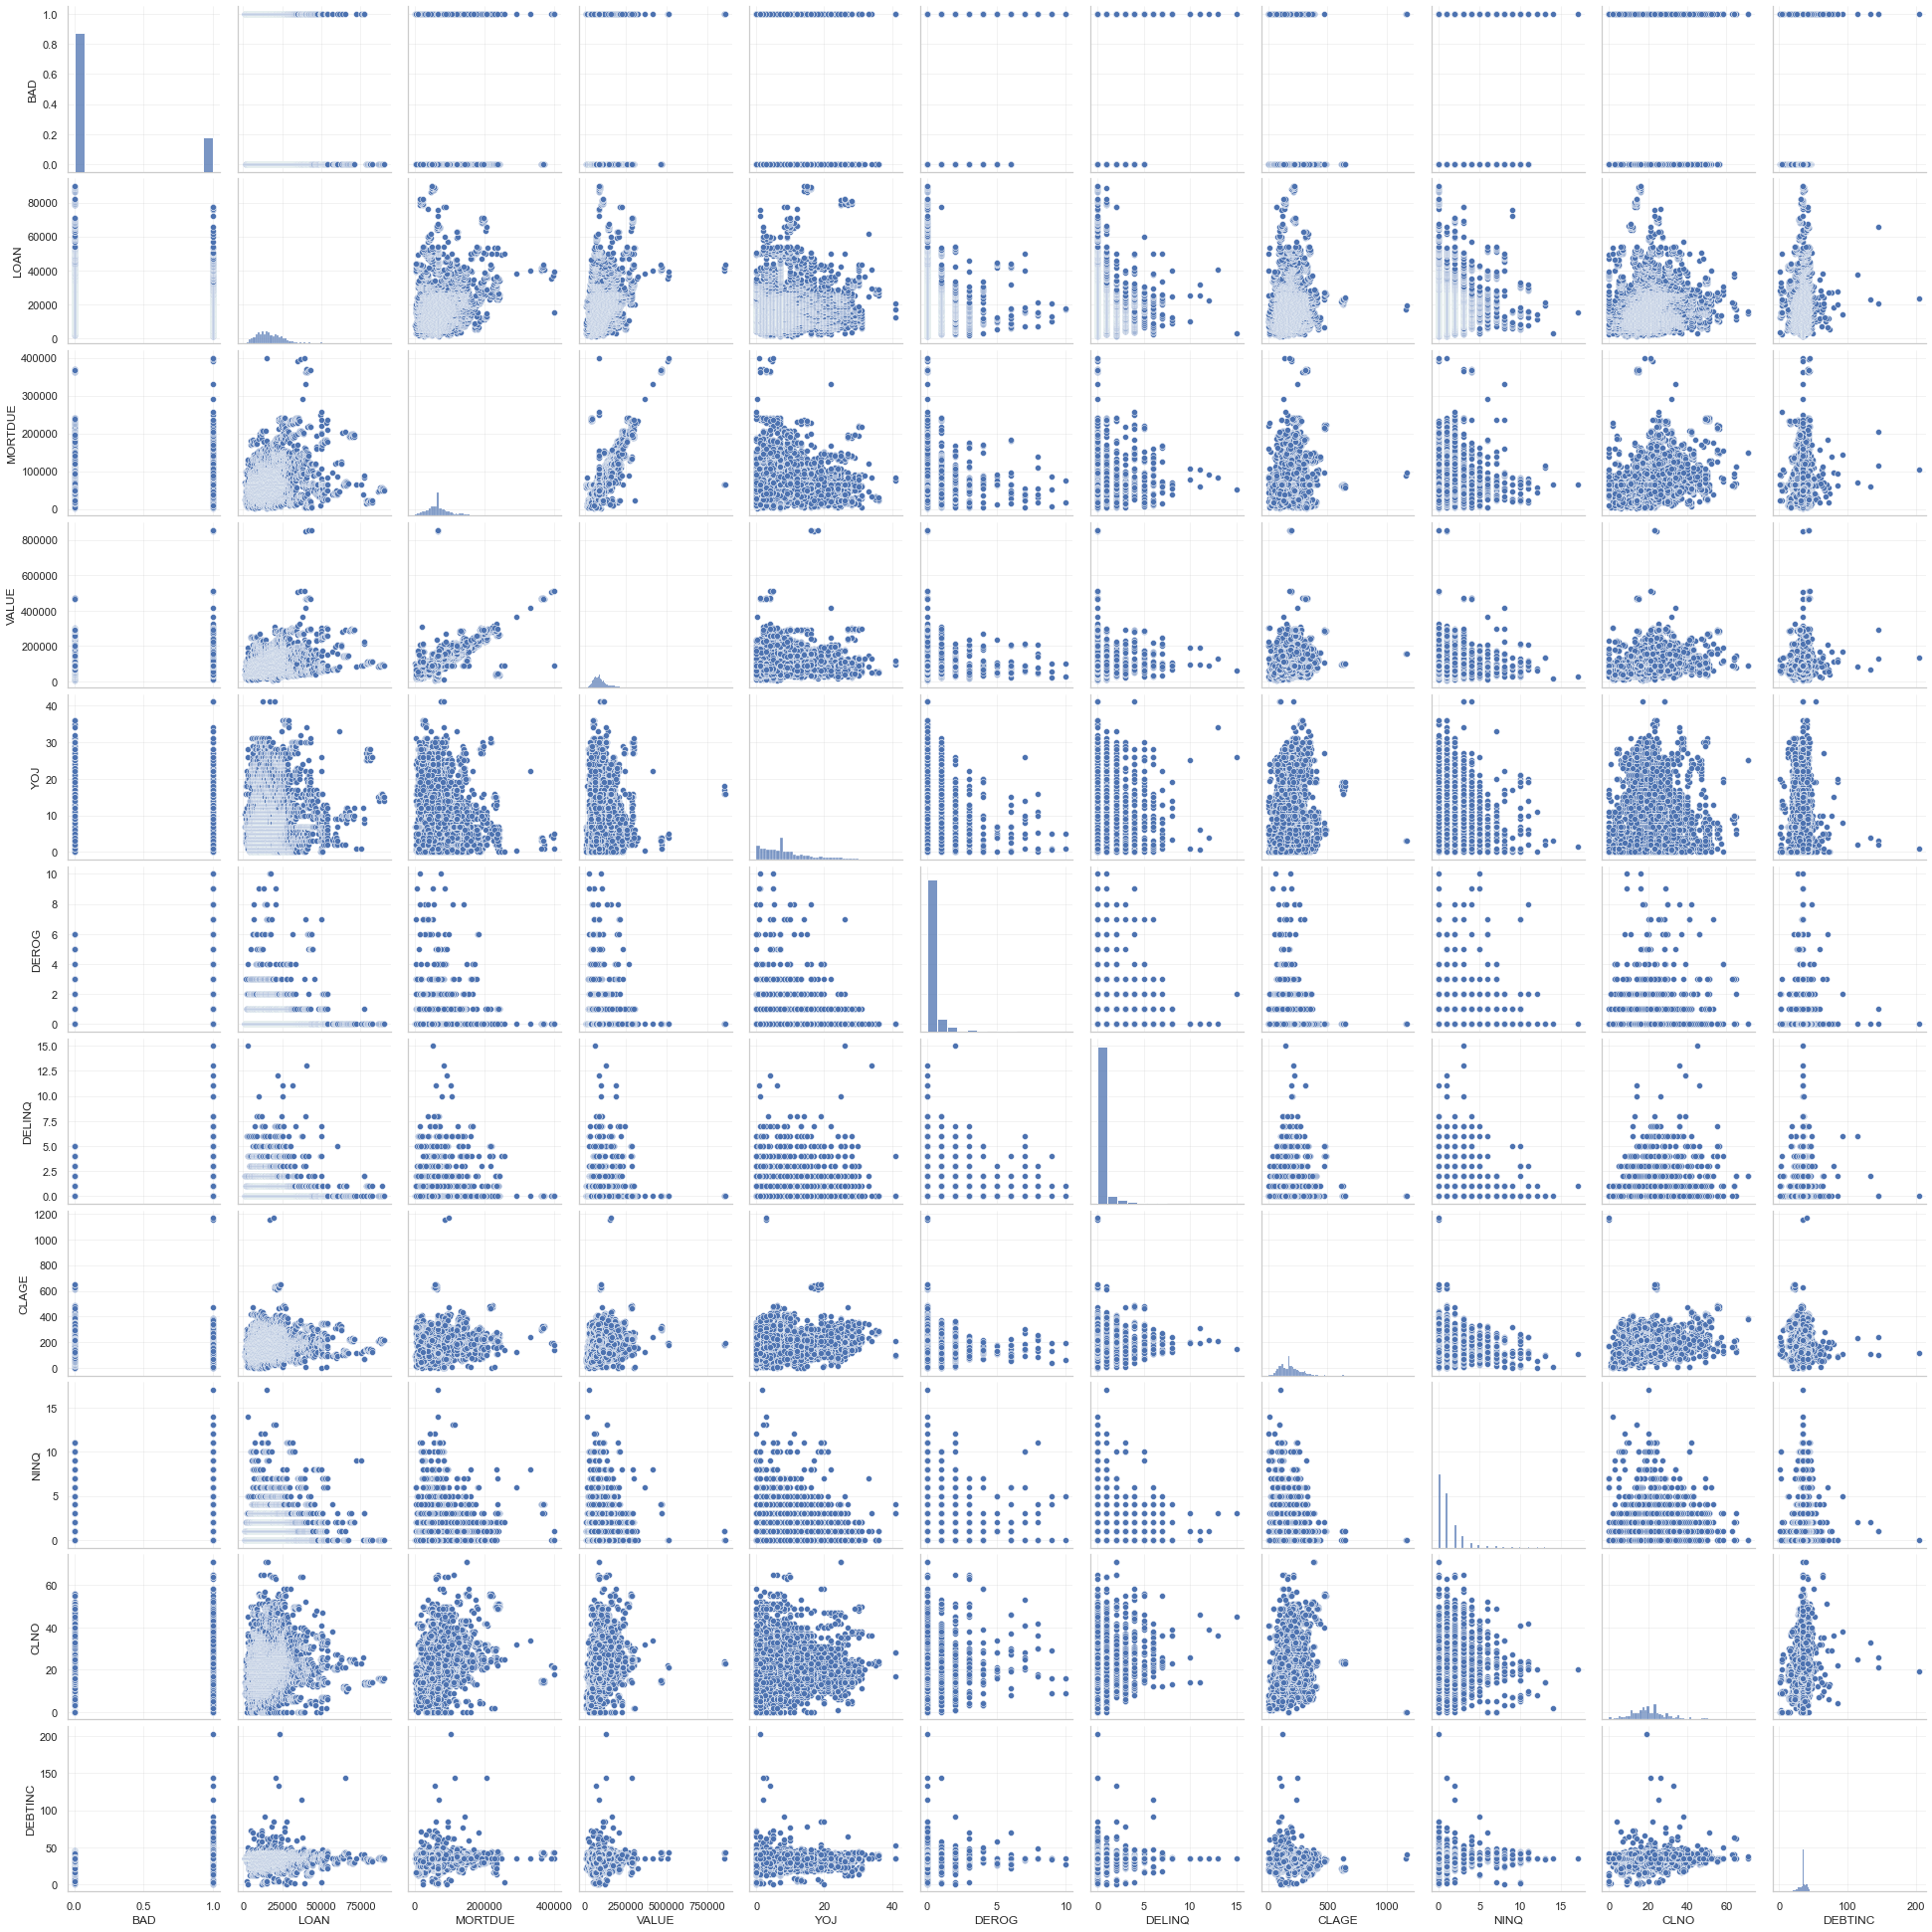

time: 38.6 s (started: 2022-01-01 18:09:04 +07:00)


In [36]:
# Correlation feature using pairplot
sns.pairplot(df)
plt.show()

# Feature Engineering

Pada tahap feature engineering ini akan dilakukan pembuatan feature baru dari feature yang sudah ada, merubah data menjadi format yang dapat dibaca oleh model ML, dan rescaling.

In [37]:
# Add new feature from existing data
df['PROBINC'] = df['MORTDUE']/df['DEBTINC'] # adding new feature, (current debt on mortgage)/(debt to income ratio)

time: 0 ns (started: 2022-01-01 18:09:43 +07:00)


## Feature Encoding

### One Hot Encoding

Lakukan one hot encoding pada feature non-numeric, yaitu feature JOB dan REASON dan gabungkan hasil encoding dengan dataframe awal agar lebih mudah dipahami.

In [38]:
# One Hot Encoding using dummies
encoded = pd.get_dummies(df[['REASON', 'JOB']], prefix=['reason', 'job'])

# Merge dataframe
df = pd.concat([df, encoded], axis=1)

# Delete REASON and JOB features
df.drop(['REASON', 'JOB'], axis=1, inplace=True)
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,PROBINC,reason_DebtCon,reason_HomeImp,reason_Other,job_Mgr,job_Office,job_Other,job_ProfExe,job_Sales,job_Self
0,1,1100,25860.0,39025.0,10.5,0.0,0,94.366667,1,9,...,742.713698,0,1,0,0,0,1,0,0,0
1,1,1300,70053.0,68400.0,7.0,0.0,2,121.833333,0,14,...,2011.961435,0,1,0,0,0,1,0,0,0
2,1,1500,13500.0,16700.0,4.0,0.0,0,149.466667,1,10,...,387.727569,0,1,0,0,0,1,0,0,0
3,1,1500,65019.0,89235.5,7.0,0.0,0,173.466667,1,20,...,1867.382132,0,0,1,0,0,1,0,0,0
4,0,1700,97800.0,112000.0,3.0,0.0,0,93.333333,0,14,...,2808.870831,0,1,0,0,1,0,0,0,0


time: 156 ms (started: 2022-01-01 18:09:43 +07:00)


## Feature Scaling

Pisahkan antara feature dan target.

In [39]:
# Separate features and targets
x = df.drop(['BAD'], axis=1)
y = df['BAD']

time: 0 ns (started: 2022-01-01 18:09:43 +07:00)


Karena pada data yang kita miliki terdapat banyak outliers, maka kita lakukan scaling menggunakan RobustScaling.

In [40]:
# Scaling features
transformed = RobustScaler().fit_transform(x)

# Create a scaled dataframe
df_scaled = pd.DataFrame(transformed, columns=x.columns)
df_scaled['BAD'] = y
df_scaled

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,...,reason_DebtCon,reason_HomeImp,reason_Other,job_Mgr,job_Office,job_Other,job_ProfExe,job_Sales,job_Self,BAD
0,-1.245902,-0.977478,-0.956113,0.388889,0.0,0.0,-0.720587,0.0,-1.000000,0.000000,...,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,-1.229508,0.125658,-0.396751,0.000000,0.0,2.0,-0.470370,-0.5,-0.545455,0.000000,...,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,-1.213115,-1.286006,-1.381227,-0.333333,0.0,0.0,-0.218636,0.0,-0.909091,0.000000,...,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3,-1.213115,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,-1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,-1.196721,0.818272,0.433484,-0.444444,0.0,0.0,-0.730000,-0.5,-0.545455,0.000000,...,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,5.950820,-0.193579,0.018080,1.000000,0.0,0.0,0.440387,-0.5,-0.363636,0.180066,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
5956,5.959016,-0.260676,0.070484,1.000000,0.0,0.0,0.320897,-0.5,-0.454545,0.144949,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
5957,5.975410,-0.273931,0.070237,0.888889,0.0,0.0,0.353580,-0.5,-0.454545,0.102735,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
5958,6.024590,-0.365665,0.049995,0.777778,0.0,0.0,0.368274,-0.5,-0.363636,-0.066425,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


time: 156 ms (started: 2022-01-01 18:09:43 +07:00)


# Sampling Dataset

## Separating Train and Test Set 

Pada tahap ini kita akan memisalkan data latih dan data uji untuk nantinya digunakan pada model yang akan kita latih.

In [41]:
# Separate features and target

X = df_scaled.drop('BAD', axis=1)
y = df_scaled['BAD']

time: 0 ns (started: 2022-01-01 18:09:44 +07:00)


In [42]:
# Separate train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

time: 156 ms (started: 2022-01-01 18:09:44 +07:00)


In [43]:
# Dimension train and test set
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4172, 20) (4172,) (1788, 20) (1788,)
time: 93 ms (started: 2022-01-01 18:09:44 +07:00)


## Imbalanced Class

Karena target yang kita punya class nya tidak terdistribusi normal, maka kita akan lakukan over sampling dengan menggunakan metode SMOTE. 

In [44]:
# Check target distribution 
pd.Series(y_train).value_counts()

0    3382
1     790
Name: BAD, dtype: int64

time: 16 ms (started: 2022-01-01 18:09:44 +07:00)


### Over Sampling Using SMOTE

In [45]:
# Applying SMOTE
X_over, y_over = SMOTE().fit_resample(X_train, y_train)

# Make sure classes are evenly distributed
pd.Series(y_over).value_counts()

1    3382
0    3382
Name: BAD, dtype: int64

time: 78 ms (started: 2022-01-01 18:09:44 +07:00)


# Modelling

Pada tahap modeling ini kita melakukan beberapa tahapan, yaitu memilih model yang terbaik, melakukan tuning hyperparamater pada model yang dipilih, lakukan evaluasi model, dan simpan model.

## Choose The Best Classifier

Pada tahap ini kita akan menggunakan beberapa metode yang nantinya kita lihat performanya, model dengan performa terbaik akan kita lakukan tuning pada tahap selanjutnya.

In [46]:
# Define classier to a list
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(), 
    AdaBoostClassifier(), 
    ExtraTreesClassifier(), 
    GradientBoostingClassifier(), 
    BaggingClassifier(),
    KNeighborsClassifier(), 
    LogisticRegression(),
    GaussianNB(), 
    SVC()]

time: 15 ms (started: 2022-01-01 18:09:44 +07:00)


In [47]:
# Create dataframe for model performance result
model_performance = pd.DataFrame(columns=['Method', 'accuracy', 'precision', 'recall', 'f1-score'])

time: 156 ms (started: 2022-01-01 18:09:44 +07:00)


In [48]:
# Train data for each model
for classifier in classifiers:
    classifier.fit(X_over, y_over)
    y_pred = classifier.predict(X_test)

    method = str(type(classifier)).split('.')[-1][:-2]

    # accuracy score
    acc = accuracy_score(y_test, y_pred)

    # precision score
    pre = precision_score(y_test, y_pred)

    # recall score
    re = recall_score(y_test, y_pred)

    # f1 score
    f1 = f1_score(y_test, y_pred)

    # Append model performance metrics to dataframe
    model_performance = model_performance.append({
        'Method':method,
        'accuracy':acc,
        'precision':pre,
        'recall':re,
        'f1-score':f1}, ignore_index=True)

time: 13.6 s (started: 2022-01-01 18:09:45 +07:00)


In [49]:
# Sort accuracy, precision, recall, and f2-score in descending order
model_performance.sort_values(['accuracy', 'precision', 'recall', 'f1-score'], ascending=False).reset_index(drop=True)

,Method,accuracy,precision,recall,f1-score
0,ExtraTreesClassifier,0.937919,0.936364,0.774436,0.847737
1,KNeighborsClassifier,0.926174,0.873950,0.781955,0.825397
2,RandomForestClassifier,0.918904,0.843243,0.781955,0.811443
3,BaggingClassifier,0.883110,0.755376,0.704261,0.728923
4,GradientBoostingClassifier,0.874161,0.703271,0.754386,0.727932
5,DecisionTreeClassifier,0.862975,0.695431,0.686717,0.691047
6,AdaBoostClassifier,0.838367,0.614583,0.739348,0.671217
7,SVC,0.794183,0.528131,0.729323,0.612632
8,GaussianNB,0.776286,0.498471,0.408521,0.449036
9,LogisticRegression,0.737696,0.440678,0.651629,0.525784


time: 47 ms (started: 2022-01-01 18:09:58 +07:00)


Pada hasil percobaan yang sudah dilakukan, terlihat bahwa model ExtraTreesClassifier memiliki performa terbaik, maka kita akan lakukan tuning pada model ini.

## Tuning Hyperparameters

Lakukan tuning hyperparameters pada model ExtraTreesClassifier untuk menghasilkan performa performa terbaik.

In [50]:
clf = ExtraTreesClassifier()

# Define parameters
params = {
    'n_estimators': range(0,201,25),
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap':[True, False],
    }

# Applying grid search
grid_result = GridSearchCV(clf, params, scoring='f1', cv=5)


time: 47 ms (started: 2022-01-01 18:09:58 +07:00)


In [51]:
# Fit grid search 
grid_result.fit(X_over, y_over)

# Display best score and best parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.986712 using {'bootstrap': False, 'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 200}
time: 8min 37s (started: 2022-01-01 18:09:59 +07:00)


## Model Performance

Setelah didapatkan parameter terbaik, maka kita tinggal melatih model yang sudah kita pilih menggunakan parameter tersebut.

In [52]:
# Applying best parameters to model
clf = ExtraTreesClassifier(**grid_result.best_params_)
clf.fit(X_over, y_over)

ExtraTreesClassifier(max_features='log2', n_estimators=200)

time: 2.67 s (started: 2022-01-01 18:18:37 +07:00)


### Confusion Matrix

In [53]:
# Prediction data test
y_pred = clf.predict(X_test)

# Confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
            columns = ['pred 0', 'pred 1'],
            index = ['act 0', 'act 1'])
cm_df

,pred 0,pred 1
act 0,1370,19
act 1,85,314


time: 234 ms (started: 2022-01-01 18:18:39 +07:00)


Pada hasil confusion matrix didapatkan hasil 1368 terprediksi benar class 0 (pemohon gagal membayar) dan 312 terprediksi class 1 (pemohon membayar).

### Classification Report

In [54]:
# Classification report model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1389
           1       0.94      0.79      0.86       399

    accuracy                           0.94      1788
   macro avg       0.94      0.89      0.91      1788
weighted avg       0.94      0.94      0.94      1788

time: 16 ms (started: 2022-01-01 18:18:40 +07:00)


Pada hasil diatas, baik accuracy, precision, recall dan f1-score memiliki nilai yang cukup baik, yaitu diatas 75%, dengan nilai akurasi 94%.

### Feature Importance

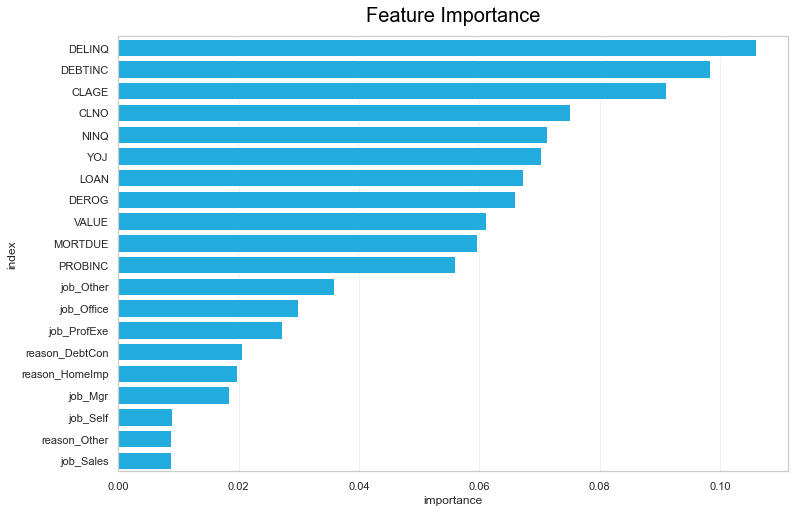

time: 672 ms (started: 2022-01-01 18:18:40 +07:00)


In [55]:
# Assign feature importance to the dataframe
feature_importance = pd.DataFrame(
    clf.feature_importances_, 
    index=X.columns, 
    columns=['importance']).sort_values('importance', ascending=False).reset_index()

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='importance', y='index', color='#03bafc')
plt.title('Feature Importance', fontsize=20, color='black', pad=15)
plt.show()

## Save Model

In [56]:
# Save model with joblib
joblib.dump(clf,'extratree')

['extratree']

time: 484 ms (started: 2022-01-01 18:18:40 +07:00)


# Summary

### Korelasi Feature dan Target
- Pada data yang dilatih class yang dominan yaitu class 0 (pemohon berhasil membayar)
- Distribusi jumlah pinjaman antara class 0 dan class 1 memiliki distribusi yang sama, maka bisa dikatakan jumlah pinjaman tidak berpengaruh kepada pemohon gagal membayar
-  Distribusi pemohon yang gagal membayar dan tidak cenderung sama pada pada setiap alasan peminjaman, jadi bisa dikatakan alasan peminjaman tidak berpengaruh kepada gagalnya pembayaran pinjaman
- Jumlah laporan penghinaan utama, jumlah kredit menunggak cukup tinggi memiliki korelasi positif yang cukup tinggi pada faktor kegagalan pemohon membayar. Karena secara umum semakin banyak kredit mengunggak maka semakin sulit juga untuk membayar.

### Model Performance
- Pada hasil percobaan didapatkan bahwa model Extra Tree Classifier memiliki performa terbaik dari beberapa model yang digunakan, dengan akurasi mencapai 94%.
- Dilakukan tuning hyperparameter untuk memilih parameter terbaik yang akan digunakan dalam training model.
- Dari hasil confusion matrix didapatkan TP dan TN yang tinggi, maka bisa di katakan model dapat mengklasifikasi dengan cukup baik dengan akurasi mencapai 94%. 